## Predicting a song's energy level based on its characteristics: a spotipy project
> Prepared by Austin Spivey, Final Project, GA Data Science, February-April 2022

## Objective
> Using Python's spotipy package, understand how a given song's characteristics affect its "energy" level. 

>> Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

## Table of Contents
1. Imports, installing spotipy, and faciliating Spotify API connection
2. Pull, arrange, clean, and explore Spotify data
3. Linear Regression: using loudness to predict energy
4. Multiple Regression: using loudness, genre, and valence to predict energy
5. Polynomial Regression
6. Random Forest Regression
7. Neural Network
8. K-Means Clustering

## Supporting Material
> [spotipy documentation](https://spotipy.readthedocs.io/)

> [Spotify documentation on song characteristics](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features)

---

### Imports

In [1]:
import spotipy
import sys
import spotipy.oauth2 as oauth2
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score

In [2]:
import warnings
warnings.simplefilter("ignore")

### Installing spotipy package

In [3]:
# pip install spotipy

### Running some terminal code to facilitate API connection

In [4]:
# Created Spotify for Developers account, collected Client ID and Secret ID.

In [5]:
# Ran the following commands in terminal to create permanent environment variables.

# touch ~/.zshenv
# open -a TextEdit.app ~/.zshenv
# export SPOTIPY_CLIENT_ID='21c381a7bb944ba697c4832bd3c145be'
# export SPOTIPY_CLIENT_SECRET='21c381a7bb944ba697c4832bd3c145be'
# export SPOTIPY_REDIRECT_URI='http://localhost/'
# source ~/.zshenv

### Testing the API connection: Pulling U2's discography

In [6]:
bono_uri = 'spotify:artist:51Blml2LZPmy7TTiAg47vQ'
spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())

results = spotify.artist_albums(bono_uri, album_type='album')
albums = results['items']
while results['next']:
    results = spotify.next(results)
    albums.extend(results['items'])

for album in albums:
    print(album['name'])

Achtung Baby (30th Anniversary Edition)
Achtung Baby (30th Anniversary Edition)
All That You Can’t Leave Behind (20th Anniversary Edition / Super Deluxe / Remastered 2020)
Songs Of Experience (Deluxe Edition)
Songs Of Experience (Deluxe Edition)
Songs Of Innocence
Songs Of Innocence
Songs Of Innocence (Deluxe)
Songs Of Innocence (Deluxe)
No Line On The Horizon
No Line On The Horizon
Boy
Under A Blood Red Sky
War
October
Boy (Deluxe Version)
How To Dismantle An Atomic Bomb
How To Dismantle An Atomic Bomb
All That You Can't Leave Behind
All That You Can't Leave Behind
Pop
Zooropa
Achtung Baby (Deluxe Edition)
Achtung Baby
Rattle And Hum
The Joshua Tree
The Joshua Tree
The Joshua Tree (Deluxe)
The Joshua Tree (Super Deluxe)
The Joshua Tree (Super Deluxe)
The Unforgettable Fire
The Unforgettable Fire (Deluxe Edition Remastered)
The Unforgettable Fire (Deluxe Edition Remastered)
The Unforgettable Fire (Remastered)
War
War (Remastered)
War (Deluxe Bonus eAlbum)
War (Deluxe Edition Remastered

### My top artists in the short, medium and long terms

In [7]:
from spotipy.oauth2 import SpotifyOAuth

scope = 'user-top-read'
ranges = ['short_term', 'medium_term', 'long_term']

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))

for sp_range in ['short_term', 'medium_term', 'long_term']:
    print("range:", sp_range)

    results = sp.current_user_top_artists(time_range=sp_range, limit=50)

    for i, item in enumerate(results['items']):
        print(i, item['name'])
    print()

range: short_term
0 Eleri Ward
1 LÉON
2 St. Lucia
3 Justin Bieber
4 Pritam
5 Allen Stone
6 Amos Lee
7 ABBA
8 One Direction
9 Coldplay
10 Michael Jackson
11 Bee Gees
12 KC & The Sunshine Band
13 The Killers
14 Jimmy Buffett
15 Max Richter
16 U2
17 Sister Sledge
18 Maroon 5
19 Avicii
20 BYU Singers
21 H.E.R.
22 Bruce Springsteen
23 Leon Bridges
24 Ariana Grande
25 Fleetwood Mac
26 Maggie Rogers
27 Leith Ross
28 Sam Fender
29 Jacob Collier
30 John Mayer
31 Amber Mark
32 Black Eyed Peas
33 Dave Matthews Band
34 Bahamas
35 Jason Mraz
36 Doja Cat
37 NEEDTOBREATHE
38 Ed Sheeran
39 JD McPherson
40 Zac Brown Band
41 Pitbull
42 CHIC
43 Bruno Mars
44 David Guetta
45 Tom Jones
46 Donna Summer
47 Tedeschi Trucks Band
48 Nelly Furtado
49 Kool & The Gang

range: medium_term
0 Sam Fender
1 Allen Stone
2 Adele
3 Coldplay
4 St. Lucia
5 The 1975
6 U2
7 Ed Sheeran
8 Pritam
9 Maroon 5
10 LÉON
11 Eleri Ward
12 Foy Vance
13 ABBA
14 John Mayer
15 Ray LaMontagne
16 Instrumental Guitar Masters
17 Ariana Grande


### Creating DataFrames of Spotify playlist data

#### Getting started with a df of just one playlist

In [8]:
def analyze_playlist(creator, playlist_id):
    
    # Create empty dataframe
    playlist_features_list = ["artist", "album", "track_name", "track_id", 
                             "danceability", "energy", "key", "loudness", "mode", "speechiness",
                             "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature"]
    playlist_df = pd.DataFrame(columns = playlist_features_list)
    
    # Create empty dict
    playlist_features = {}
    
    # Loop through every track in the playlist, extract features and append the features to the playlist df
    playlist = sp.user_playlist_tracks(creator, playlist_id)["items"]
    for track in playlist:
        # Get metadata
        playlist_features["artist"] = track["track"]["album"]["artists"][0]["name"]
        playlist_features["album"] = track["track"]["album"]["name"]
        playlist_features["track_name"] = track["track"]["name"]
        playlist_features["track_id"] = track["track"]["id"]
        # Get audio features
        audio_features = sp.audio_features(playlist_features["track_id"])[0]
        try:
            for feature in playlist_features_list[4:]:
                playlist_features[feature] = audio_features[feature]
        except:
            pass
        
        # Concat the dfs
        track_df = pd.DataFrame(playlist_features, index = [0])
        playlist_df = pd.concat([playlist_df, track_df], ignore_index = True)
        
    return playlist_df

In [9]:
playlist_creator = "spotify"
playlist_id = "37i9dQZF1DXaXB8fQg7xif"
playlist_df = analyze_playlist(playlist_creator, playlist_id)

In [10]:
playlist_df.head()

artist                      album                  track_name  \
0           Kygo  Dancing Feet (feat. DNCE)   Dancing Feet (feat. DNCE)   
1     KAYTRANADA                Intimidated  Intimidated (feat. H.E.R.)   
2     Elton John    Cold Heart (PNAU Remix)     Cold Heart - PNAU Remix   
3      BLOND:ISH                       Sete                        Sete   
4  Years & Years               Sweet Talker                Sweet Talker   

                 track_id  danceability  energy key  loudness mode  \
0  4RAR8g8fZNB106ezUurnE0         0.750   0.797   0    -4.826    1   
1  0dFdGPVLs3k0z9ezYWZzUa         0.738   0.750  11    -3.654    0   
2  6zSpb8dQRaw0M1dK8PBwQz         0.796   0.798   1    -6.312    1   
3  5B4gUqNKYgU38ULSWP5Bzj         0.736   0.827   6    -3.902    0   
4  6FRxFke9VsjXmibGgSeKki         0.429   0.905  10    -2.930    1   

   speechiness instrumentalness  liveness  valence    tempo duration_ms  \
0       0.1180                0    0.3920    0.523  105.949      215203   
1       0.2190          0.00976    0.1740    0.342  112.009      207840   
2       0.0317         0.000042    0.0952    0.942  116.032      202735   
3       0.0643          0.00828    0.3510    0.814  125.008      209760   
4       0.0512                0    0.0714    0.659  121.025      176930   

  time_signature  
0              4  
1              4  
2              4  
3              4  
4              4

#### Using a dictionary to create a df with multiple playlists from dance, exercise, and work Spotify playlists

In [11]:
playlist_dict = {
    "dance_party" : ("spotify", "37i9dQZF1DXaXB8fQg7xif"),
    "dance_classics" : ("spotify", "37i9dQZF1DX8a1tdzq5tbM"),
    "dance_rising" : ("spotify", "37i9dQZF1DX8tZsk68tuDw"), 
    "happy_beats" : ("spotify", "37i9dQZF1DWSf2RDTDayIx"),
    "dance_hits" : ("spotify", "37i9dQZF1DX0BcQWzuB7ZO"), 
    "mint" : ("spotify", "37i9dQZF1DX4dyzvuaRJ0n"),
    "viral_dance" : ("spotify", "37i9dQZF1DX5IDTimEWoTd"), 
    "beast_mode" : ("spotify", "37i9dQZF1DX76Wlfdnj7AP"),
    "pumped_pop" : ("spotify", "37i9dQZF1DX5gQonLbZD9s"), 
    "locked_in" : ("spotify", "37i9dQZF1DWTl4y3vgJOXW"),
    "hype" : ("spotify", "37i9dQZF1DX4eRPd9frC1m"), 
    "workout" : ("spotify", "37i9dQZF1DX70RN3TfWWJh"),
    "power_hour" : ("spotify", "37i9dQZF1DX32NsLKyzScr"), 
    "cardio" : ("spotify", "37i9dQZF1DWSJHnPb1f0X3"),
    "music_for_a_workday" : ("spotify", "37i9dQZF1DXcsT4WKI8W8r"),
    "work_from_home" : ("spotify", "37i9dQZF1DWTLSN7iG21yC"),
    "this_is_work_music" : ("spotify", "37i9dQZF1DZ06evO2dBn56"),
    "workday_lounge" : ("spotify", "37i9dQZF1DWT5lkChsPmpy"),
    "this_is_office_work_music" : ("spotify", "37i9dQZF1DZ06evO1yGVXy"),
    "productive_morning" : ("spotify", "37i9dQZF1DX6T5dWVv97mp"),
    "your_office_stereo" : ("spotify", "37i9dQZF1DX31KQt69Gaqf")
}

In [12]:
def analyze_playlist_dict(playlist_dict):
    
    # Loop through every playlist in the dict and analyze it
    for i, (key, val) in enumerate(playlist_dict.items()):
        playlist_df = analyze_playlist(*val)
        # Add a playlist column so that we can see which playlist a track belongs to
        playlist_df["playlist"] = key
        # Create or concat df
        if i == 0:
            playlist_dict_df = playlist_df
        else:
            playlist_dict_df = pd.concat([playlist_dict_df, playlist_df], ignore_index = True)
            
    return playlist_dict_df

In [13]:
multiple_playlist_df = analyze_playlist_dict(playlist_dict)

In [14]:
multiple_playlist_df.head()

artist                      album                  track_name  \
0           Kygo  Dancing Feet (feat. DNCE)   Dancing Feet (feat. DNCE)   
1     KAYTRANADA                Intimidated  Intimidated (feat. H.E.R.)   
2     Elton John    Cold Heart (PNAU Remix)     Cold Heart - PNAU Remix   
3      BLOND:ISH                       Sete                        Sete   
4  Years & Years               Sweet Talker                Sweet Talker   

                 track_id  danceability  energy key  loudness mode  \
0  4RAR8g8fZNB106ezUurnE0         0.750   0.797   0    -4.826    1   
1  0dFdGPVLs3k0z9ezYWZzUa         0.738   0.750  11    -3.654    0   
2  6zSpb8dQRaw0M1dK8PBwQz         0.796   0.798   1    -6.312    1   
3  5B4gUqNKYgU38ULSWP5Bzj         0.736   0.827   6    -3.902    0   
4  6FRxFke9VsjXmibGgSeKki         0.429   0.905  10    -2.930    1   

   speechiness instrumentalness  liveness  valence    tempo duration_ms  \
0       0.1180                0    0.3920    0.523  105.949      215203   
1       0.2190          0.00976    0.1740    0.342  112.009      207840   
2       0.0317         0.000042    0.0952    0.942  116.032      202735   
3       0.0643          0.00828    0.3510    0.814  125.008      209760   
4       0.0512                0    0.0714    0.659  121.025      176930   

  time_signature     playlist  
0              4  dance_party  
1              4  dance_party  
2              4  dance_party  
3              4  dance_party  
4              4  dance_party

In [15]:
multiple_playlist_df.tail()

artist                     album                track_name  \
1883   Fenne Lily                  Alapathy                  Alapathy   
1884  Biffy Clyro  A Celebration Of Endings                     Space   
1885       Dekker  Tethered, Wrapped Around  Tethered, Wrapped Around   
1886          Uly                cold water                cold water   
1887    SAM DOTIA               Uriah's Cry               Uriah's Cry   

                    track_id  danceability  energy key  loudness mode  \
1883  3UUjYLkGzItgoyEwdEtq9e         0.554   0.911   8    -6.282    1   
1884  20wnO4hGXbWvIPDEmED8gM         0.457   0.559  10    -5.170    1   
1885  6wFHsAZrmqPBuqIHofO74H         0.769   0.238   1   -11.598    1   
1886  3keIh8QdhxlHQ0hsyDHrzA         0.617   0.107  11   -18.342    1   
1887  2rtLK9Nj9PzMabMOYb4Tmd         0.329   0.128   4   -16.762    1   

      speechiness instrumentalness  liveness  valence    tempo duration_ms  \
1883       0.0292            0.542    0.0668    0.968  157.621      194973   
1884       0.0270              0.0    0.1930    0.410  156.907      235947   
1885       0.0555           0.0461    0.1160    0.706   92.093      195955   
1886       0.0685            0.697    0.1030    0.166  141.970      233239   
1887       0.0397          0.00331    0.0622    0.138  142.960      201270   

     time_signature            playlist  
1883              4  your_office_stereo  
1884              3  your_office_stereo  
1885              4  your_office_stereo  
1886              4  your_office_stereo  
1887              4  your_office_stereo

### Add a genre column to signify dance, exercise, or work music

In [16]:
def which_genre(row):
   if row['playlist'] == 'dance_party' :
      return '0'
   if row['playlist'] == 'dance_classics' :
      return '0' 
   if row['playlist'] == 'dance_rising' :
      return '0'
   if row['playlist'] == 'happy_beats' :
      return '0' 
   if row['playlist'] == 'dance_hits' :
      return '0'
   if row['playlist'] == 'mint' :
      return '0'
   if row['playlist'] == 'viral_dance' :
      return '0'
   if row['playlist'] == 'beast_mode' :
      return '1'
   if row['playlist'] == 'pumped_pop' :
      return '1'
   if row['playlist'] == 'locked_in' :
      return '1'
   if row['playlist'] == 'hype' :
      return '1'
   if row['playlist'] == 'workout' :
      return '1'
   if row['playlist'] == 'power_hour' :
      return '1'
   if row['playlist'] == 'cardio' :
      return '1'
   if row['playlist'] == 'music_for_a_workday' :
      return '2'
   if row['playlist'] == 'work_from_home' :
      return '2'
   if row['playlist'] == 'this_is_work_music' :
      return '2'
   if row['playlist'] == 'workday_lounge' :
      return '2'
   if row['playlist'] == 'this_is_office_work_music' :
      return '2'
   if row['playlist'] == 'productive_morning' :
      return '2'
   if row['playlist'] == 'your_office_stereo' :
      return '2'

In [17]:
multiple_playlist_df.apply (lambda row: which_genre(row), axis=1) # looks good

0       0
1       0
2       0
3       0
4       0
       ..
1883    2
1884    2
1885    2
1886    2
1887    2
Length: 1888, dtype: object

In [18]:
# new column
multiple_playlist_df['genre'] = multiple_playlist_df.apply (lambda row: which_genre(row), axis=1)

In [19]:
multiple_playlist_df.drop(['track_id', 'key', 'mode', 'duration_ms', 'time_signature'], axis = 1, inplace = True)

In [20]:
multiple_playlist_df.head()

artist                      album                  track_name  \
0           Kygo  Dancing Feet (feat. DNCE)   Dancing Feet (feat. DNCE)   
1     KAYTRANADA                Intimidated  Intimidated (feat. H.E.R.)   
2     Elton John    Cold Heart (PNAU Remix)     Cold Heart - PNAU Remix   
3      BLOND:ISH                       Sete                        Sete   
4  Years & Years               Sweet Talker                Sweet Talker   

   danceability  energy  loudness  speechiness instrumentalness  liveness  \
0         0.750   0.797    -4.826       0.1180                0    0.3920   
1         0.738   0.750    -3.654       0.2190          0.00976    0.1740   
2         0.796   0.798    -6.312       0.0317         0.000042    0.0952   
3         0.736   0.827    -3.902       0.0643          0.00828    0.3510   
4         0.429   0.905    -2.930       0.0512                0    0.0714   

   valence    tempo     playlist genre  
0    0.523  105.949  dance_party     0  
1    0.342  112.009  dance_party     0  
2    0.942  116.032  dance_party     0  
3    0.814  125.008  dance_party     0  
4    0.659  121.025  dance_party     0

### Cleaning and exploration of the DataFrame

In [21]:
df = multiple_playlist_df # for my sanity

In [22]:
df.shape

(1888, 13)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1888 entries, 0 to 1887
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist            1888 non-null   object 
 1   album             1888 non-null   object 
 2   track_name        1888 non-null   object 
 3   danceability      1887 non-null   float64
 4   energy            1887 non-null   float64
 5   loudness          1887 non-null   float64
 6   speechiness       1887 non-null   float64
 7   instrumentalness  1887 non-null   object 
 8   liveness          1887 non-null   float64
 9   valence           1887 non-null   float64
 10  tempo             1887 non-null   float64
 11  playlist          1888 non-null   object 
 12  genre             1888 non-null   object 
dtypes: float64(7), object(6)
memory usage: 191.9+ KB


In [24]:
df.describe()

danceability       energy     loudness  speechiness     liveness  \
count   1887.000000  1887.000000  1887.000000  1887.000000  1887.000000   
mean       0.649520     0.675479    -7.552140     0.079063     0.181002   
std        0.148998     0.234546     4.977627     0.081553     0.138903   
min        0.060300     0.001400   -40.038000     0.023500     0.025700   
25%        0.588000     0.556000    -8.358500     0.037000     0.096400   
50%        0.672000     0.740000    -6.137000     0.047800     0.124000   
75%        0.744000     0.852000    -4.788500     0.077400     0.224000   
max        0.971000     0.999000     0.352000     0.741000     0.948000   

           valence        tempo  
count  1887.000000  1887.000000  
mean      0.467156   121.525841  
std       0.240413    22.231971  
min       0.000010    49.148000  
25%       0.289000   111.055500  
50%       0.467000   123.980000  
75%       0.649500   128.021000  
max       0.973000   205.272000

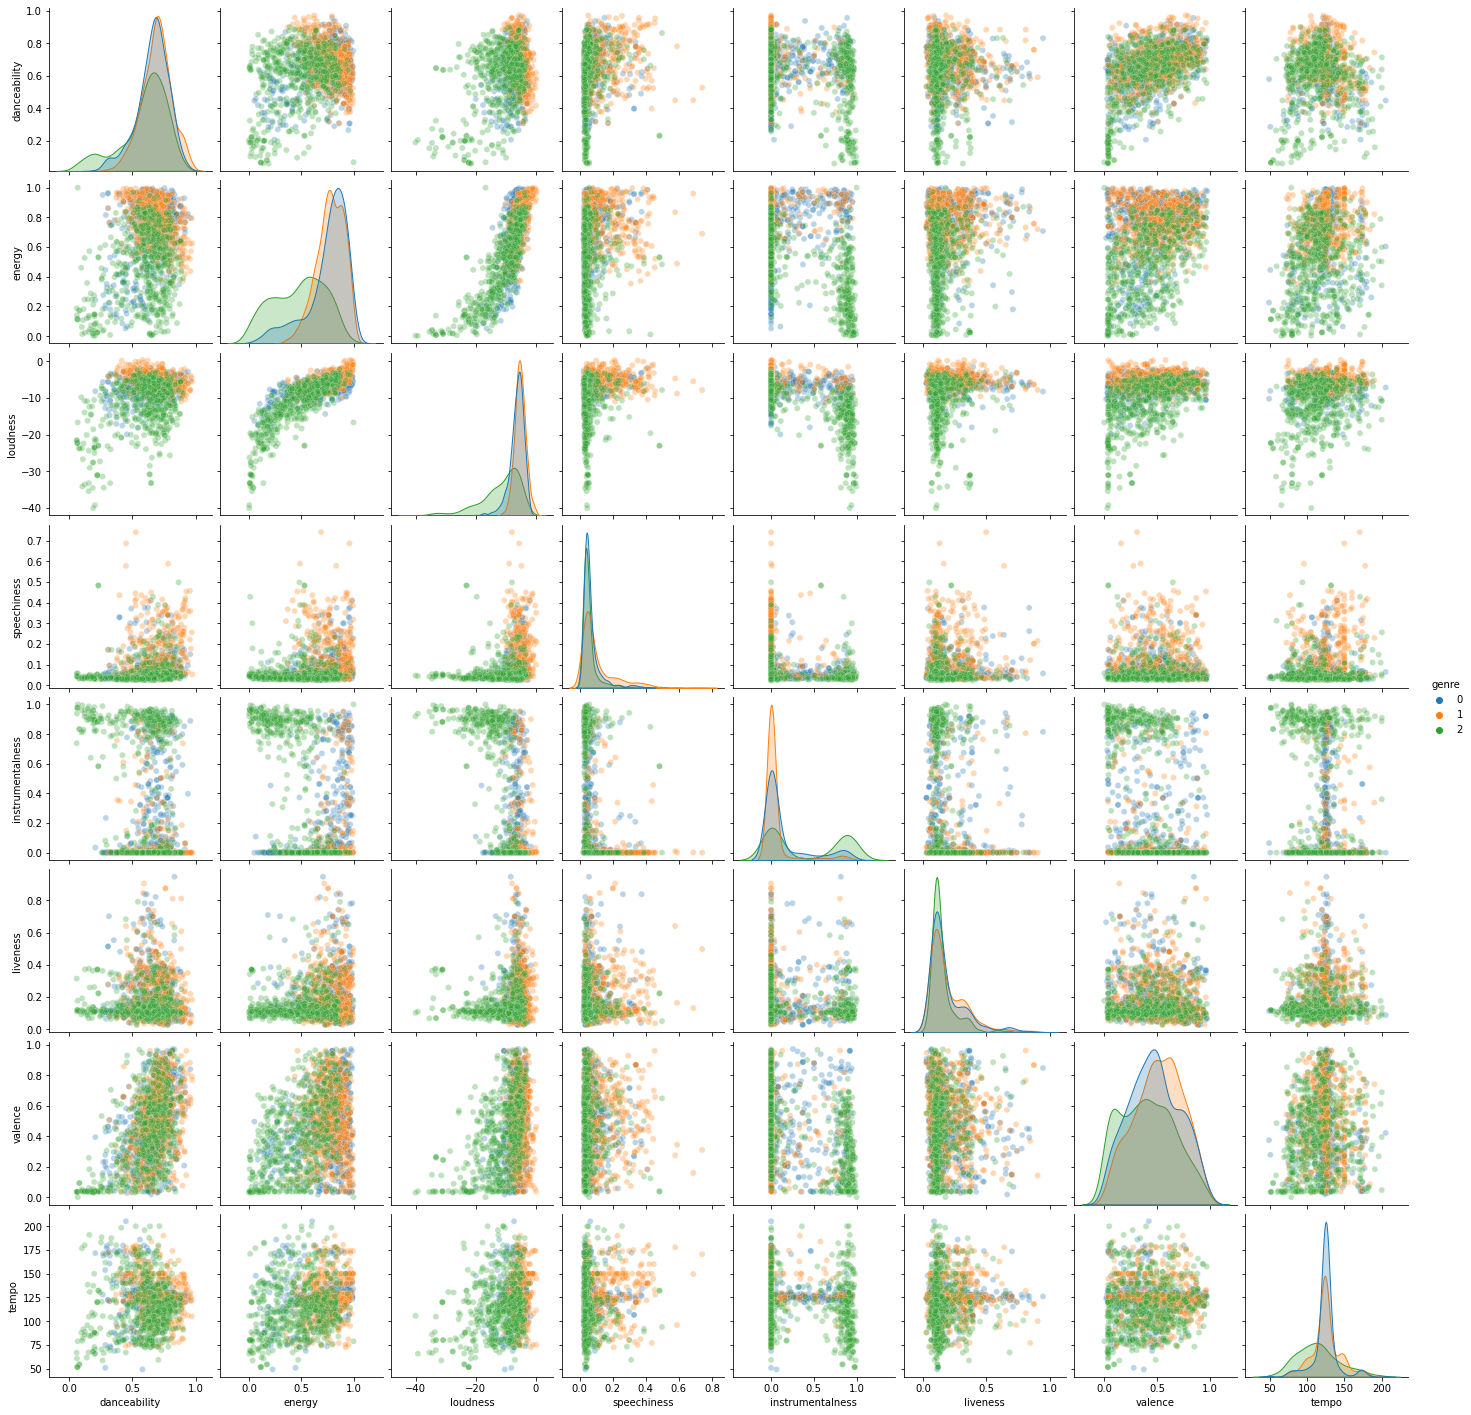

In [25]:
sns.pairplot(df, hue ='genre', plot_kws={'alpha':0.3})
plt.show()

In [26]:
corr = df.corr()
corr['energy'].sort_values(ascending = False)

energy          1.000000
loudness        0.809367
valence         0.335445
danceability    0.280286
tempo           0.260679
liveness        0.165209
speechiness     0.113380
Name: energy, dtype: float64

In [27]:
df.isna().sum()

artist              0
album               0
track_name          0
danceability        1
energy              1
loudness            1
speechiness         1
instrumentalness    1
liveness            1
valence             1
tempo               1
playlist            0
genre               0
dtype: int64

In [28]:
df.dropna(axis=0, how="any", thresh=None, subset=None, inplace=True)

In [29]:
df.isna().sum()

artist              0
album               0
track_name          0
danceability        0
energy              0
loudness            0
speechiness         0
instrumentalness    0
liveness            0
valence             0
tempo               0
playlist            0
genre               0
dtype: int64

In [30]:
# The most energetic song in the df is this ocean sounds track. Makes sense in a way.
df.iloc[df['energy'].idxmax()]

artist                                   Nature Sounds
album               Nature: Sea Storm Relaxation Music
track_name                                Ocean Escape
danceability                                    0.0684
energy                                           0.999
loudness                                       -16.681
speechiness                                     0.0579
instrumentalness                                   1.0
liveness                                         0.176
valence                                        0.00001
tempo                                            78.84
playlist                            this_is_work_music
genre                                                2
Name: 1561, dtype: object

### Linear Regression: using loudness to predict energy

> The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.

In [31]:
# Simple linear regression using loudness to predict energy
X_lr = df[['loudness']]
y = df['energy']
X_train, X_test, y_train, y_test = train_test_split(X_lr, y, random_state=42)

In [32]:
lr = LinearRegression()

In [33]:
lr.fit(X_train, y_train)

LinearRegression()

In [34]:
lr.score(X_train, y_train)

0.658032045791784

In [35]:
lr.score(X_test, y_test)

0.642169815233107

In [36]:
scores = cross_val_score(lr, X_train, y_train, cv = 5, scoring='neg_mean_squared_error')

In [37]:
lr_rmse_scores = np.sqrt(-scores)

In [38]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [39]:
display_scores(lr_rmse_scores)

Scores: [0.13571964 0.14341336 0.1288468  0.13106404 0.14342281]
Mean: 0.13649333174620654
Standard deviation: 0.00607370868782623


In [40]:
yhat_lr = lr.predict(X_test) # establishing predicted value of y for visualization

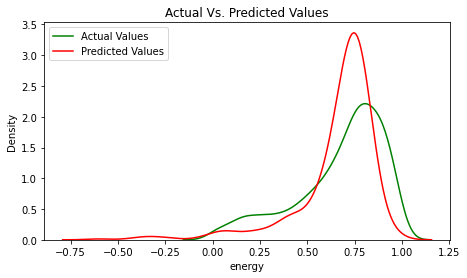

In [41]:
fig, axes = plt.subplots(1,2, figsize=(16,4))
sns.distplot(y, hist=False, color="g", label="Actual Values",ax=axes[0])
sns.distplot(yhat_lr, hist=False, color="r", label="Predicted Values" , ax=axes[0])
fig.delaxes(axes[1])
axes[0].set_title("Actual Vs. Predicted Values")
axes[0].legend();

#### Conclusion
> With linear regression, we are able to use a song's loudness to predict its energy with 64% accuracy.

### Multiple Regression: using loudness, genre, and valence to predict energy 

> Valence is a measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

In [42]:
X_mr = df[['loudness','genre','valence']]
y = df['energy']
X_train, X_test, y_train, y_test = train_test_split(X_mr, y, random_state=42)

In [43]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [44]:
lr.score(X_train, y_train)

0.673864022935418

In [45]:
lr.score(X_test, y_test)

0.6691065978430224

In [46]:
scores = cross_val_score(lr, X_train, y_train, cv = 5, scoring='neg_mean_squared_error')

In [47]:
mr_rmse_scores = np.sqrt(-scores)

In [48]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [49]:
display_scores(scores)

Scores: [-0.01776017 -0.02059262 -0.01517649 -0.01679635 -0.01898301]
Mean: -0.017861728810630577
Standard deviation: 0.0018477499378550459


In [50]:
yhat_mr = lr.predict(X_train)

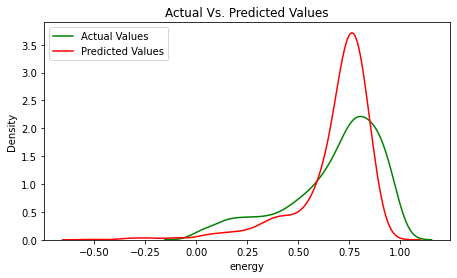

In [51]:
# The slightest improvement on linear regression
fig, axes = plt.subplots(1,2, figsize=(16,4))
sns.distplot(y, hist=False, color="g", label="Actual Values",ax=axes[0])
sns.distplot(yhat_mr, hist=False, color="r", label="Predicted Values" , ax=axes[0])
fig.delaxes(axes[1])
axes[0].set_title("Actual Vs. Predicted Values")
axes[0].legend();

#### Conclusion
> With multiple regression, we are able to use a song's loudness, genre, and valence to predict its energy with 67% accuracy. This is a 3% improvement on our results from linear regression.

### Polynomial Regression

In [169]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=4, include_bias=False)
X_poly = poly_features.fit_transform(X_mr)
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, random_state=42)

In [161]:
lr.fit(X_train, y_train)

LinearRegression()

In [162]:
lr.score(X_train, y_train) 

0.7354736968798304

In [163]:
lr.score(X_test, y_test) 

0.744662299377022

In [164]:
scores = cross_val_score(lr, X_train, y_train, cv = 5, scoring='neg_mean_squared_error')

poly_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [165]:
display_scores(scores)

Scores: [-0.01535822 -0.01510536 -0.01288805 -0.01450186 -0.01770261]
Mean: -0.015111218539837806
Standard deviation: 0.0015550011723006157


In [166]:
yhat_poly = lr.predict(X_train)

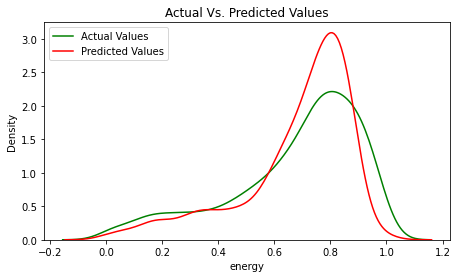

In [167]:
fig, axes = plt.subplots(1,2, figsize=(16,4))
sns.distplot(y, hist=False, color="g", label="Actual Values",ax=axes[0])
sns.distplot(yhat_poly, hist=False, color="r", label="Predicted Values" , ax=axes[0])
fig.delaxes(axes[1])
axes[0].set_title("Actual Vs. Predicted Values")
axes[0].legend();

### Searching for optimal polynomial degree

Best degree 1 with RMSE 0.1198893732798275


Text(0.5, 1.0, 'Best Polynomial Degree by RMSE')

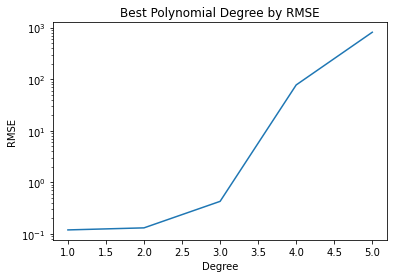

In [168]:
rmses = []
degrees = np.arange(1, 6)
min_rmse, min_deg = 1e10, 1

for deg in degrees:

    # Train features
    poly_features_new = PolynomialFeatures(degree=deg, include_bias=False)
    x_poly_train = poly_features_new.fit_transform(X_train)

    # Linear regression
    poly_reg = LinearRegression()
    poly_reg.fit(x_poly_train, y_train)

    # Compare with test data
    x_poly_test = poly_features_new.fit_transform(X_test)
    poly_predict = poly_reg.predict(x_poly_test)
    poly_mse = mean_squared_error(y_test, poly_predict)
    poly_rmse = np.sqrt(poly_mse)
    rmses.append(poly_rmse)
    
    # Cross-validation of degree
    if min_rmse > poly_rmse:
        min_rmse = poly_rmse
        min_deg = deg

# Plot and present results
print('Best degree {} with RMSE {}'.format(min_deg, min_rmse))
        
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(degrees, rmses)
ax.set_yscale('log')
ax.set_xlabel('Degree')
ax.set_ylabel('RMSE')
plt.title('Best Polynomial Degree by RMSE')

#### Conclusion
> With polynomial regression, we are able to use a song's loudness, genre, and valence to predict its energy with 75% accuracy, with the optimal polynomial degree set to 4. This is an 11% improvement on our results from linear regression and a 7% improvement on our results from multiple regression.

### Random Forest Regressor

In [60]:
X_forest = df[['genre','loudness','valence']]
y = df['energy']

In [61]:
from sklearn.ensemble import RandomForestRegressor
X_train_forest, X_test_forest, y_train_forest, y_test_forest = train_test_split(X_forest, y, random_state=42)
model = RandomForestRegressor(random_state=42, max_depth=4).fit(X_train_forest, y_train_forest)

In [62]:
model.score(X_train_forest, y_train_forest)

0.7481311597221643

In [63]:
model.score(X_test_forest, y_test_forest) 

0.7334987816732013

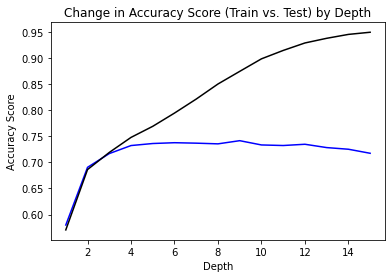

In [64]:
scores = []
scores_train = []
depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
for max_depth in depths:
    model = RandomForestRegressor(max_depth = max_depth)
    model.fit(X_train_forest, y_train_forest)
    scores.append(model.score(X_test_forest, y_test_forest))
    scores_train.append(model.score(X_train_forest, y_train_forest))

fig, ax = plt.subplots()
ax.plot(depths, scores, c="blue")
ax.plot(depths, scores_train, c="black")
plt.xlabel('Depth') 
plt.ylabel('Accuracy Score') 
plt.title('Change in Accuracy Score (Train vs. Test) by Depth');

In [65]:
yhat_forest = model.predict(X_train_forest)

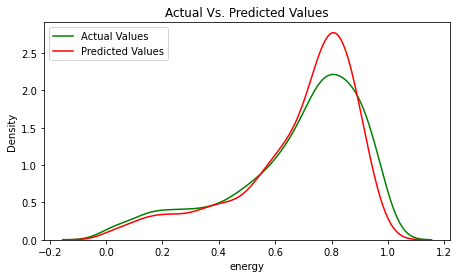

In [66]:
fig, axes = plt.subplots(1,2, figsize=(16,4))
sns.distplot(y, hist=False, color="g", label="Actual Values",ax=axes[0])
sns.distplot(yhat_forest, hist=False, color="r", label="Predicted Values" , ax=axes[0])
fig.delaxes(axes[1])
axes[0].set_title("Actual Vs. Predicted Values")
axes[0].legend();

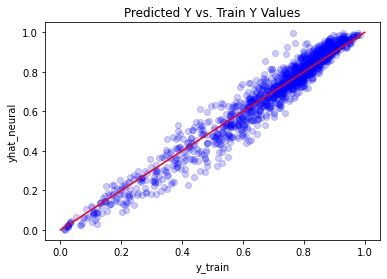

In [67]:
plt.scatter(yhat_forest, y_train_forest, c="blue", alpha=0.2)
plt.plot([0, 1], [0,1], c="red")
plt.xlabel('y_train') 
plt.ylabel('yhat_neural') 
plt.title('Predicted Y vs. Train Y Values')
plt.show()

#### Conclusion
> With random forest regression, with max_depth set to 4, we are able to use a song's loudness, genre, and valence to predict its energy with 73% accuracy. This is a 10% improvement on our results from linear regression, a 6% improvement on our results from multiple regression and a -1% decline from our results from polynomial regression, degree 4. Still, as demonstrated by the predicted y vs. train y values, this is the strongest model in this project.
>> It should be noted that overfitting occurs starting with a max_depth of 5, and the model loses reliability after this point for predictions on test data. It is clear that this is a difficult prediction problem, and gains in accuracy after this point would likely take some effort.

### Neural network

In [107]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
network = Sequential()
X_neural = df[['genre','loudness','valence']]
X_neural_float = np.asarray(X_neural).astype('float32')
y = df['energy']

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X_neural_float, y, random_state=42)

In [109]:
X_train.shape

(1415, 3)

In [110]:
X_test.shape

(472, 3)

In [111]:
network.add(Dense(3, activation='relu'))
network.add(Dense(50, activation='relu'))
network.add(Dense(50, activation='relu'))
network.add(Dense(50, activation='relu'))
network.add(Dense(50, activation='relu'))
network.add(Dense(50, activation='relu'))
network.add(Dense(1, activation='linear'))

In [112]:
network.compile(loss = 'mae', # regression
                optimizer = 'adam',
                metrics = ['mse'])

In [113]:
history = network.fit(X_train, y_train, 
            validation_data = (X_test, y_test),
            epochs = 2000)

Epoch 1/2000
45/45 [==============================] - 1s 4ms/step - loss: 0.3919 - mse: 0.2523 - val_loss: 0.2917 - val_mse: 0.2029
Epoch 2/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.1875 - mse: 0.0689 - val_loss: 0.1504 - val_mse: 0.0355
Epoch 3/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.1256 - mse: 0.0265 - val_loss: 0.1207 - val_mse: 0.0239
Epoch 4/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.1180 - mse: 0.0242 - val_loss: 0.1213 - val_mse: 0.0234
Epoch 5/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.1147 - mse: 0.0223 - val_loss: 0.1305 - val_mse: 0.0274
Epoch 6/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.1164 - mse: 0.0234 - val_loss: 0.1237 - val_mse: 0.0266
Epoch 7/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.1165 - mse: 0.0234 - val_loss: 0.1118 - val_mse: 0.0212
Epoch 8/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.

45/45 [==============================] - 0s 2ms/step - loss: 0.0974 - mse: 0.0167 - val_loss: 0.0933 - val_mse: 0.0153
Epoch 124/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0958 - mse: 0.0162 - val_loss: 0.0953 - val_mse: 0.0158
Epoch 125/2000
45/45 [==============================] - 0s 1ms/step - loss: 0.0963 - mse: 0.0163 - val_loss: 0.0943 - val_mse: 0.0155
Epoch 126/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0953 - mse: 0.0160 - val_loss: 0.0950 - val_mse: 0.0162
Epoch 127/2000
45/45 [==============================] - 0s 1ms/step - loss: 0.0961 - mse: 0.0162 - val_loss: 0.0925 - val_mse: 0.0153
Epoch 128/2000
45/45 [==============================] - 0s 1ms/step - loss: 0.0949 - mse: 0.0160 - val_loss: 0.0923 - val_mse: 0.0153
Epoch 129/2000
45/45 [==============================] - 0s 1ms/step - loss: 0.0962 - mse: 0.0163 - val_loss: 0.0922 - val_mse: 0.0152
Epoch 130/2000
45/45 [==============================] - 0s 1ms/step - loss: 0

45/45 [==============================] - 0s 1ms/step - loss: 0.0973 - mse: 0.0164 - val_loss: 0.0933 - val_mse: 0.0153
Epoch 246/2000
45/45 [==============================] - 0s 1ms/step - loss: 0.0955 - mse: 0.0161 - val_loss: 0.0919 - val_mse: 0.0151
Epoch 247/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0952 - mse: 0.0159 - val_loss: 0.0948 - val_mse: 0.0158
Epoch 248/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0963 - mse: 0.0162 - val_loss: 0.0933 - val_mse: 0.0154
Epoch 249/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0953 - mse: 0.0160 - val_loss: 0.0921 - val_mse: 0.0151
Epoch 250/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0955 - mse: 0.0161 - val_loss: 0.0924 - val_mse: 0.0152
Epoch 251/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0960 - mse: 0.0161 - val_loss: 0.0929 - val_mse: 0.0152
Epoch 252/2000
45/45 [==============================] - 0s 2ms/step - loss: 0

45/45 [==============================] - 0s 2ms/step - loss: 0.0951 - mse: 0.0159 - val_loss: 0.0939 - val_mse: 0.0157
Epoch 368/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0964 - mse: 0.0162 - val_loss: 0.0926 - val_mse: 0.0151
Epoch 369/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0960 - mse: 0.0161 - val_loss: 0.0923 - val_mse: 0.0152
Epoch 370/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0954 - mse: 0.0160 - val_loss: 0.0924 - val_mse: 0.0152
Epoch 371/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0952 - mse: 0.0161 - val_loss: 0.0932 - val_mse: 0.0155
Epoch 372/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0954 - mse: 0.0159 - val_loss: 0.0971 - val_mse: 0.0163
Epoch 373/2000
45/45 [==============================] - 0s 1ms/step - loss: 0.0964 - mse: 0.0164 - val_loss: 0.0950 - val_mse: 0.0158
Epoch 374/2000
45/45 [==============================] - 0s 1ms/step - loss: 0

45/45 [==============================] - 0s 2ms/step - loss: 0.0965 - mse: 0.0162 - val_loss: 0.0927 - val_mse: 0.0153
Epoch 490/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0954 - mse: 0.0160 - val_loss: 0.0947 - val_mse: 0.0160
Epoch 491/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0959 - mse: 0.0160 - val_loss: 0.0924 - val_mse: 0.0152
Epoch 492/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0952 - mse: 0.0160 - val_loss: 0.0927 - val_mse: 0.0154
Epoch 493/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0955 - mse: 0.0161 - val_loss: 0.0926 - val_mse: 0.0152
Epoch 494/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0953 - mse: 0.0159 - val_loss: 0.0938 - val_mse: 0.0153
Epoch 495/2000
45/45 [==============================] - 0s 1ms/step - loss: 0.0949 - mse: 0.0158 - val_loss: 0.0927 - val_mse: 0.0154
Epoch 496/2000
45/45 [==============================] - 0s 2ms/step - loss: 0

45/45 [==============================] - 0s 2ms/step - loss: 0.0949 - mse: 0.0158 - val_loss: 0.0925 - val_mse: 0.0153
Epoch 612/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0948 - mse: 0.0158 - val_loss: 0.0948 - val_mse: 0.0159
Epoch 613/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0953 - mse: 0.0161 - val_loss: 0.0928 - val_mse: 0.0154
Epoch 614/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0948 - mse: 0.0158 - val_loss: 0.0927 - val_mse: 0.0154
Epoch 615/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0954 - mse: 0.0159 - val_loss: 0.0922 - val_mse: 0.0152
Epoch 616/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0950 - mse: 0.0159 - val_loss: 0.0926 - val_mse: 0.0153
Epoch 617/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0956 - mse: 0.0161 - val_loss: 0.0928 - val_mse: 0.0154
Epoch 618/2000
45/45 [==============================] - 0s 2ms/step - loss: 0

45/45 [==============================] - 0s 2ms/step - loss: 0.0950 - mse: 0.0159 - val_loss: 0.0932 - val_mse: 0.0155
Epoch 734/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0944 - mse: 0.0159 - val_loss: 0.0927 - val_mse: 0.0153
Epoch 735/2000
45/45 [==============================] - 0s 1ms/step - loss: 0.0949 - mse: 0.0159 - val_loss: 0.0927 - val_mse: 0.0152
Epoch 736/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0949 - mse: 0.0158 - val_loss: 0.0923 - val_mse: 0.0152
Epoch 737/2000
45/45 [==============================] - 0s 1ms/step - loss: 0.0952 - mse: 0.0160 - val_loss: 0.0934 - val_mse: 0.0155
Epoch 738/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0953 - mse: 0.0160 - val_loss: 0.0931 - val_mse: 0.0153
Epoch 739/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0951 - mse: 0.0160 - val_loss: 0.0923 - val_mse: 0.0152
Epoch 740/2000
45/45 [==============================] - 0s 2ms/step - loss: 0

45/45 [==============================] - 0s 2ms/step - loss: 0.0943 - mse: 0.0157 - val_loss: 0.0960 - val_mse: 0.0160
Epoch 856/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0947 - mse: 0.0160 - val_loss: 0.0935 - val_mse: 0.0155
Epoch 857/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0956 - mse: 0.0160 - val_loss: 0.0929 - val_mse: 0.0154
Epoch 858/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0948 - mse: 0.0158 - val_loss: 0.0952 - val_mse: 0.0158
Epoch 859/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0949 - mse: 0.0159 - val_loss: 0.0924 - val_mse: 0.0152
Epoch 860/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0949 - mse: 0.0158 - val_loss: 0.0932 - val_mse: 0.0155
Epoch 861/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0950 - mse: 0.0160 - val_loss: 0.0931 - val_mse: 0.0153
Epoch 862/2000
45/45 [==============================] - 0s 2ms/step - loss: 0

45/45 [==============================] - 0s 2ms/step - loss: 0.0948 - mse: 0.0160 - val_loss: 0.0938 - val_mse: 0.0154
Epoch 978/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0952 - mse: 0.0160 - val_loss: 0.0945 - val_mse: 0.0159
Epoch 979/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0950 - mse: 0.0159 - val_loss: 0.0971 - val_mse: 0.0162
Epoch 980/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0948 - mse: 0.0159 - val_loss: 0.0929 - val_mse: 0.0154
Epoch 981/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0945 - mse: 0.0159 - val_loss: 0.0943 - val_mse: 0.0154
Epoch 982/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0952 - mse: 0.0159 - val_loss: 0.0927 - val_mse: 0.0154
Epoch 983/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0947 - mse: 0.0159 - val_loss: 0.0928 - val_mse: 0.0152
Epoch 984/2000
45/45 [==============================] - 0s 2ms/step - loss: 0

Epoch 1038/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0957 - mse: 0.0161 - val_loss: 0.0942 - val_mse: 0.0156
Epoch 1039/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0949 - mse: 0.0161 - val_loss: 0.0934 - val_mse: 0.0154
Epoch 1040/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0947 - mse: 0.0159 - val_loss: 0.0933 - val_mse: 0.0155
Epoch 1041/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0945 - mse: 0.0159 - val_loss: 0.0923 - val_mse: 0.0152
Epoch 1042/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0941 - mse: 0.0157 - val_loss: 0.0928 - val_mse: 0.0153
Epoch 1043/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0945 - mse: 0.0158 - val_loss: 0.0924 - val_mse: 0.0152
Epoch 1044/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0948 - mse: 0.0158 - val_loss: 0.0929 - val_mse: 0.0153
Epoch 1045/2000
45/45 [==============================] 

Epoch 1159/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0944 - mse: 0.0157 - val_loss: 0.0924 - val_mse: 0.0153
Epoch 1160/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0949 - mse: 0.0159 - val_loss: 0.0924 - val_mse: 0.0153
Epoch 1161/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0948 - mse: 0.0159 - val_loss: 0.0928 - val_mse: 0.0154
Epoch 1162/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0949 - mse: 0.0159 - val_loss: 0.0924 - val_mse: 0.0153
Epoch 1163/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0948 - mse: 0.0159 - val_loss: 0.0939 - val_mse: 0.0155
Epoch 1164/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0949 - mse: 0.0158 - val_loss: 0.0928 - val_mse: 0.0154
Epoch 1165/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0945 - mse: 0.0158 - val_loss: 0.0927 - val_mse: 0.0154
Epoch 1166/2000
45/45 [==============================] 

Epoch 1280/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0945 - mse: 0.0158 - val_loss: 0.0933 - val_mse: 0.0153
Epoch 1281/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0945 - mse: 0.0158 - val_loss: 0.0931 - val_mse: 0.0154
Epoch 1282/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0944 - mse: 0.0158 - val_loss: 0.0928 - val_mse: 0.0153
Epoch 1283/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0946 - mse: 0.0159 - val_loss: 0.0926 - val_mse: 0.0152
Epoch 1284/2000
45/45 [==============================] - 0s 1ms/step - loss: 0.0949 - mse: 0.0158 - val_loss: 0.0930 - val_mse: 0.0152
Epoch 1285/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0946 - mse: 0.0158 - val_loss: 0.0930 - val_mse: 0.0153
Epoch 1286/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0945 - mse: 0.0158 - val_loss: 0.0929 - val_mse: 0.0154
Epoch 1287/2000
45/45 [==============================] 

Epoch 1401/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0948 - mse: 0.0159 - val_loss: 0.0948 - val_mse: 0.0158
Epoch 1402/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0949 - mse: 0.0159 - val_loss: 0.0925 - val_mse: 0.0152
Epoch 1403/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0946 - mse: 0.0158 - val_loss: 0.0926 - val_mse: 0.0153
Epoch 1404/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0952 - mse: 0.0160 - val_loss: 0.0946 - val_mse: 0.0155
Epoch 1405/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0951 - mse: 0.0159 - val_loss: 0.0928 - val_mse: 0.0154
Epoch 1406/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0942 - mse: 0.0157 - val_loss: 0.0946 - val_mse: 0.0156
Epoch 1407/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0949 - mse: 0.0160 - val_loss: 0.0930 - val_mse: 0.0154
Epoch 1408/2000
45/45 [==============================] 

Epoch 1522/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0947 - mse: 0.0158 - val_loss: 0.0944 - val_mse: 0.0156
Epoch 1523/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0946 - mse: 0.0158 - val_loss: 0.0932 - val_mse: 0.0154
Epoch 1524/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0952 - mse: 0.0161 - val_loss: 0.0953 - val_mse: 0.0159
Epoch 1525/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0953 - mse: 0.0160 - val_loss: 0.0927 - val_mse: 0.0153
Epoch 1526/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0946 - mse: 0.0159 - val_loss: 0.0940 - val_mse: 0.0155
Epoch 1527/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0944 - mse: 0.0157 - val_loss: 0.0926 - val_mse: 0.0152
Epoch 1528/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0946 - mse: 0.0158 - val_loss: 0.0935 - val_mse: 0.0153
Epoch 1529/2000
45/45 [==============================] 

Epoch 1643/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0946 - mse: 0.0158 - val_loss: 0.0925 - val_mse: 0.0151
Epoch 1644/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0941 - mse: 0.0157 - val_loss: 0.0941 - val_mse: 0.0155
Epoch 1645/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0946 - mse: 0.0159 - val_loss: 0.0931 - val_mse: 0.0153
Epoch 1646/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0942 - mse: 0.0157 - val_loss: 0.0948 - val_mse: 0.0158
Epoch 1647/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0947 - mse: 0.0158 - val_loss: 0.0931 - val_mse: 0.0154
Epoch 1648/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0951 - mse: 0.0159 - val_loss: 0.0932 - val_mse: 0.0155
Epoch 1649/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0952 - mse: 0.0159 - val_loss: 0.0929 - val_mse: 0.0152
Epoch 1650/2000
45/45 [==============================] 

Epoch 1764/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0952 - mse: 0.0159 - val_loss: 0.0937 - val_mse: 0.0154
Epoch 1765/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0944 - mse: 0.0158 - val_loss: 0.0925 - val_mse: 0.0152
Epoch 1766/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0945 - mse: 0.0158 - val_loss: 0.0946 - val_mse: 0.0155
Epoch 1767/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0946 - mse: 0.0159 - val_loss: 0.0928 - val_mse: 0.0153
Epoch 1768/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0946 - mse: 0.0159 - val_loss: 0.0934 - val_mse: 0.0155
Epoch 1769/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0946 - mse: 0.0159 - val_loss: 0.0939 - val_mse: 0.0155
Epoch 1770/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0944 - mse: 0.0158 - val_loss: 0.0934 - val_mse: 0.0155
Epoch 1771/2000
45/45 [==============================] 

Epoch 1885/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0944 - mse: 0.0158 - val_loss: 0.0925 - val_mse: 0.0153
Epoch 1886/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0946 - mse: 0.0158 - val_loss: 0.0925 - val_mse: 0.0153
Epoch 1887/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0942 - mse: 0.0158 - val_loss: 0.0947 - val_mse: 0.0159
Epoch 1888/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0945 - mse: 0.0159 - val_loss: 0.0930 - val_mse: 0.0154
Epoch 1889/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0945 - mse: 0.0158 - val_loss: 0.0929 - val_mse: 0.0153
Epoch 1890/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0942 - mse: 0.0158 - val_loss: 0.0930 - val_mse: 0.0153
Epoch 1891/2000
45/45 [==============================] - 0s 2ms/step - loss: 0.0945 - mse: 0.0157 - val_loss: 0.0934 - val_mse: 0.0155
Epoch 1892/2000
45/45 [==============================] 

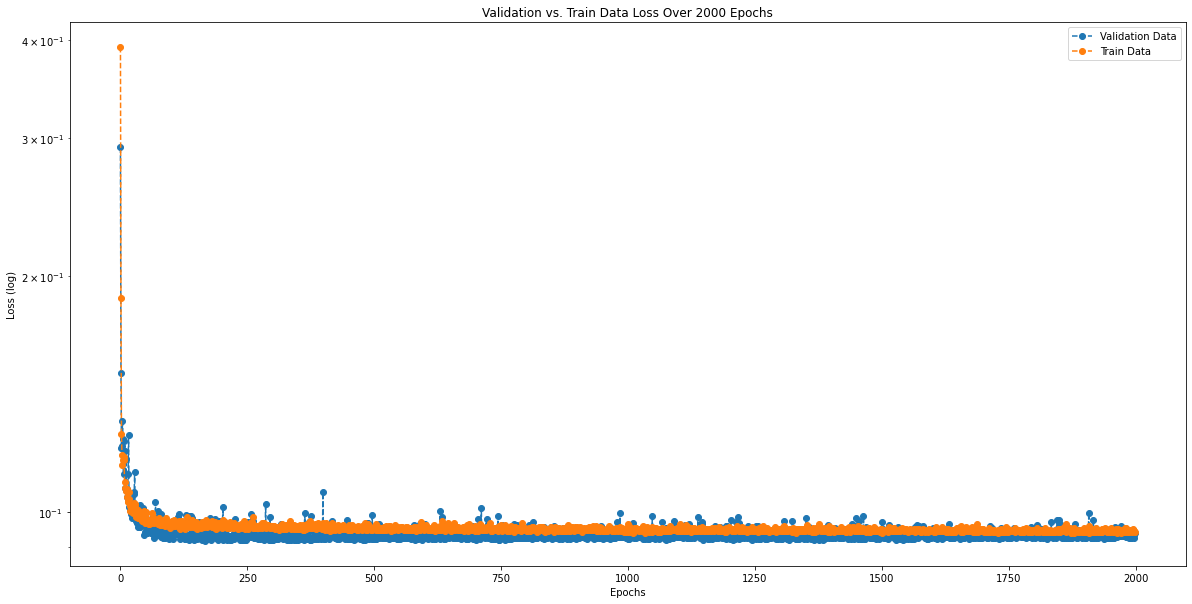

In [114]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(history.history['val_loss'], '--o', label = 'Validation Data')
ax.plot(history.history['loss'], '--o', label = 'Train Data')
ax.set_yscale('log')
plt.xlabel('Epochs') 
plt.ylabel('Loss (log)') 
plt.title('Validation vs. Train Data Loss Over 2000 Epochs')
plt.legend();

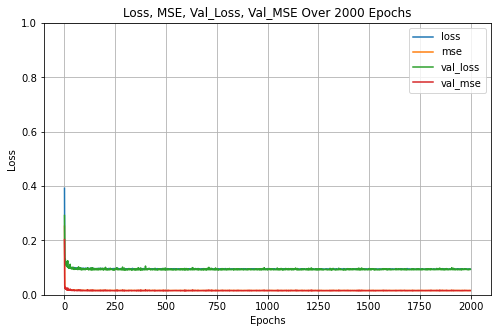

In [115]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.title('Loss, MSE, Val_Loss, Val_MSE Over 2000 Epochs')
plt.show()

In [116]:
network.predict(X_test)

array([[0.8548131 ],
       [0.7831812 ],
       [0.39656836],
       [0.6516273 ],
       [0.18837988],
       [0.12329295],
       [0.71387374],
       [0.7995213 ],
       [0.6189153 ],
       [0.8335538 ],
       [0.58770096],
       [0.61358416],
       [0.72738546],
       [0.5384705 ],
       [0.5293441 ],
       [0.7593082 ],
       [0.8146038 ],
       [0.6892015 ],
       [0.84282863],
       [0.8117988 ],
       [0.6380625 ],
       [0.7814915 ],
       [0.7342904 ],
       [0.7625276 ],
       [0.7370385 ],
       [0.7129145 ],
       [0.031004  ],
       [0.6752787 ],
       [0.8712168 ],
       [0.67370844],
       [0.65378034],
       [0.82524633],
       [0.6089705 ],
       [0.8759397 ],
       [0.5790787 ],
       [0.40562582],
       [0.97826254],
       [0.8028127 ],
       [0.72892535],
       [0.7795342 ],
       [0.3689158 ],
       [0.81067824],
       [0.7927146 ],
       [0.5363128 ],
       [0.7412009 ],
       [0.8746145 ],
       [0.6239708 ],
       [0.827

In [117]:
network.evaluate(X_test, y_test)

15/15 [==============================] - 0s 1ms/step - loss: 0.0939 - mse: 0.0155


[0.09391596913337708, 0.015502365306019783]

In [118]:
yhat_neural = network.predict(X_train)

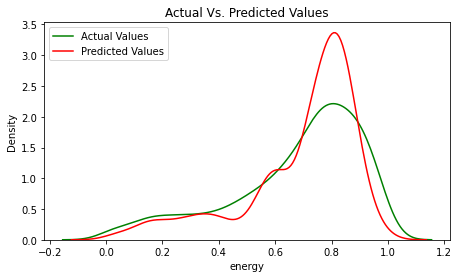

In [119]:
fig, axes = plt.subplots(1,2, figsize=(16,4))
sns.distplot(y, hist=False, color="g", label="Actual Values",ax=axes[0])
sns.distplot(yhat_neural, hist=False, color="r", label="Predicted Values" , ax=axes[0])
fig.delaxes(axes[1])
axes[0].set_title("Actual Vs. Predicted Values")
axes[0].legend();

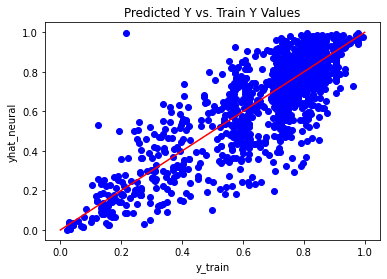

In [120]:
plt.scatter(yhat_neural, y_train, c="blue")
plt.plot([0, 1], [0,1], c="red")
plt.xlabel('y_train') 
plt.ylabel('yhat_neural') 
plt.title('Predicted Y vs. Train Y Values')
plt.show()

#### Conclusion
> Even when using a deep neural network, it's evident that we're working with a very difficult prediction problem. The neural network doesn't do quite as good a job as the random forest regressor did.

### Using k-means to find clusters

In [82]:
df.head()

artist                      album                  track_name  \
0           Kygo  Dancing Feet (feat. DNCE)   Dancing Feet (feat. DNCE)   
1     KAYTRANADA                Intimidated  Intimidated (feat. H.E.R.)   
2     Elton John    Cold Heart (PNAU Remix)     Cold Heart - PNAU Remix   
3      BLOND:ISH                       Sete                        Sete   
4  Years & Years               Sweet Talker                Sweet Talker   

   danceability  energy  loudness  speechiness instrumentalness  liveness  \
0         0.750   0.797    -4.826       0.1180                0    0.3920   
1         0.738   0.750    -3.654       0.2190          0.00976    0.1740   
2         0.796   0.798    -6.312       0.0317         0.000042    0.0952   
3         0.736   0.827    -3.902       0.0643          0.00828    0.3510   
4         0.429   0.905    -2.930       0.0512                0    0.0714   

   valence    tempo     playlist genre  
0    0.523  105.949  dance_party     0  
1    0.342  112.009  dance_party     0  
2    0.942  116.032  dance_party     0  
3    0.814  125.008  dance_party     0  
4    0.659  121.025  dance_party     0

In [83]:
X = df.iloc[:, :]

In [84]:
new_X = X.drop(['playlist', 'track_name', 'artist', 'album'], axis = 1, inplace = False)

In [85]:
new_X.head()

danceability  energy  loudness  speechiness instrumentalness  liveness  \
0         0.750   0.797    -4.826       0.1180                0    0.3920   
1         0.738   0.750    -3.654       0.2190          0.00976    0.1740   
2         0.796   0.798    -6.312       0.0317         0.000042    0.0952   
3         0.736   0.827    -3.902       0.0643          0.00828    0.3510   
4         0.429   0.905    -2.930       0.0512                0    0.0714   

   valence    tempo genre  
0    0.523  105.949     0  
1    0.342  112.009     0  
2    0.942  116.032     0  
3    0.814  125.008     0  
4    0.659  121.025     0

In [86]:
sscaler = StandardScaler()
X_scaled = sscaler.fit_transform(new_X)

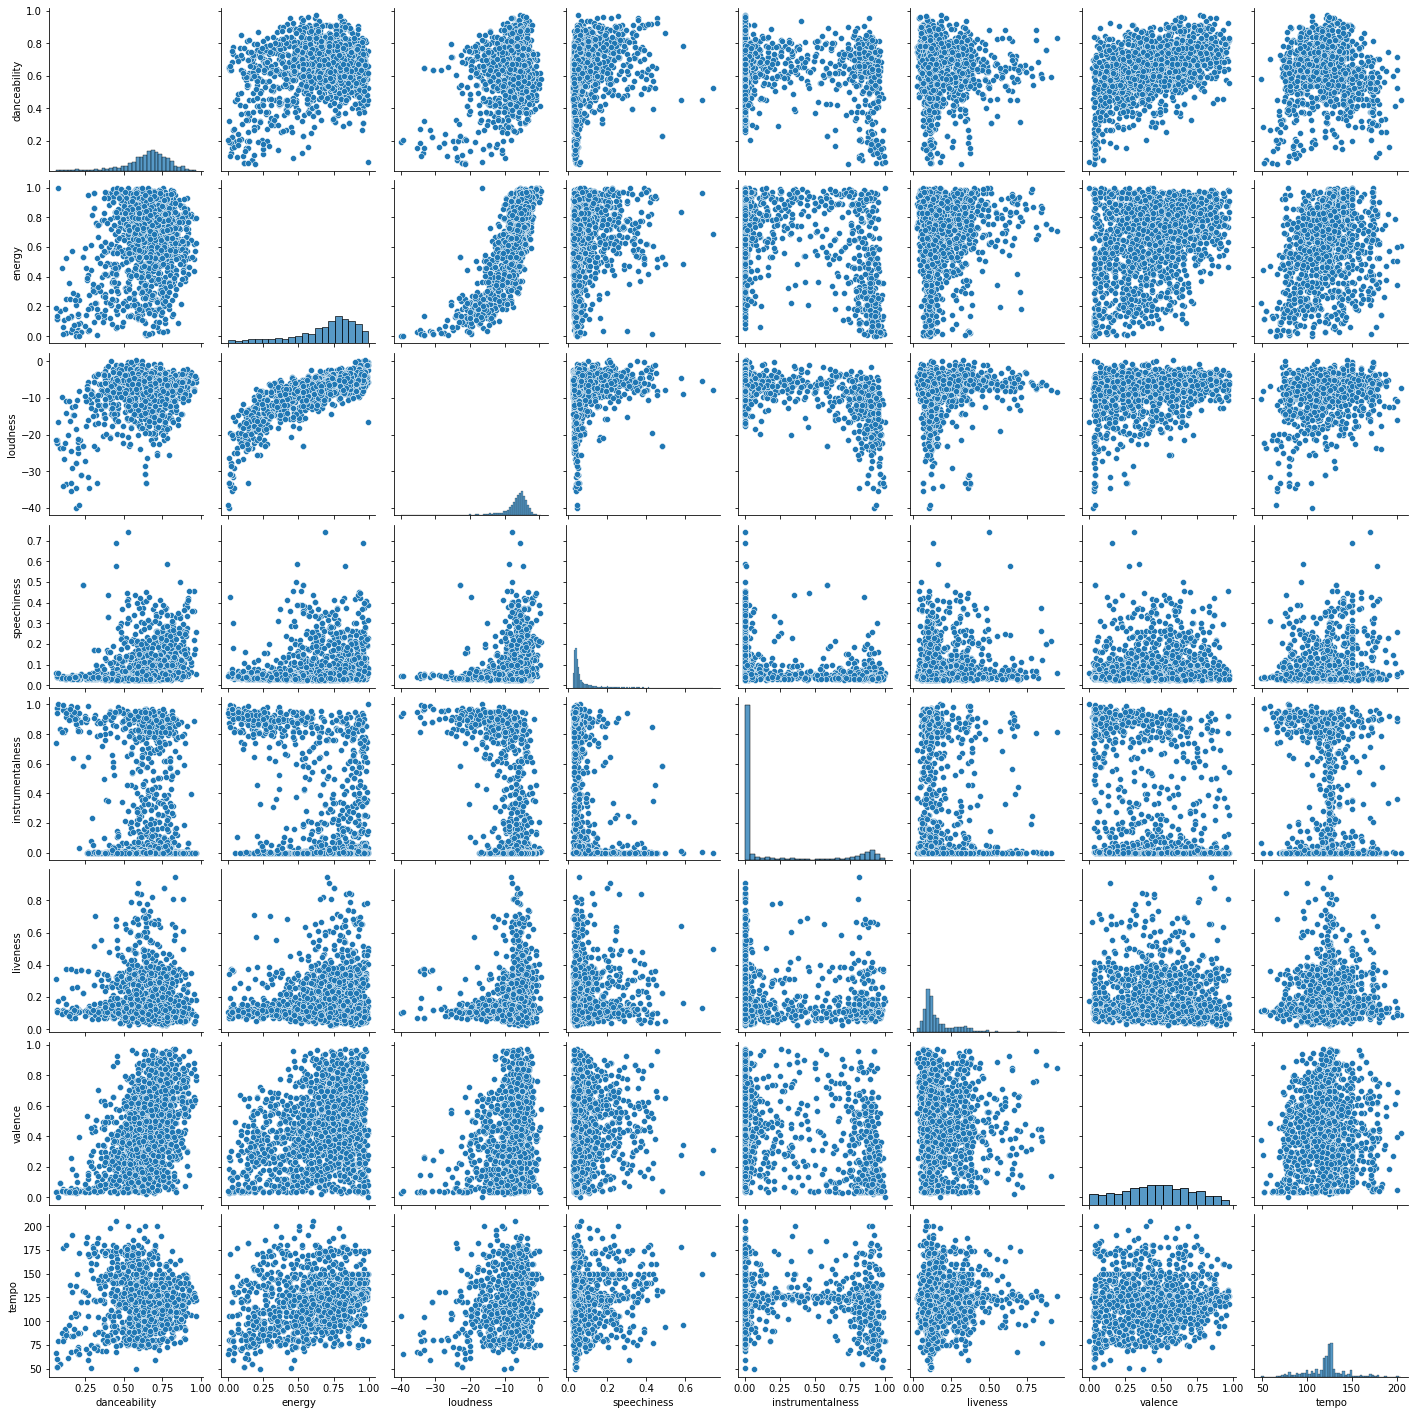

In [87]:
sns.pairplot(new_X);

In [88]:
kmeans = KMeans(n_clusters = 2).fit(X_scaled)

In [89]:
new_X['label'] = kmeans.labels_

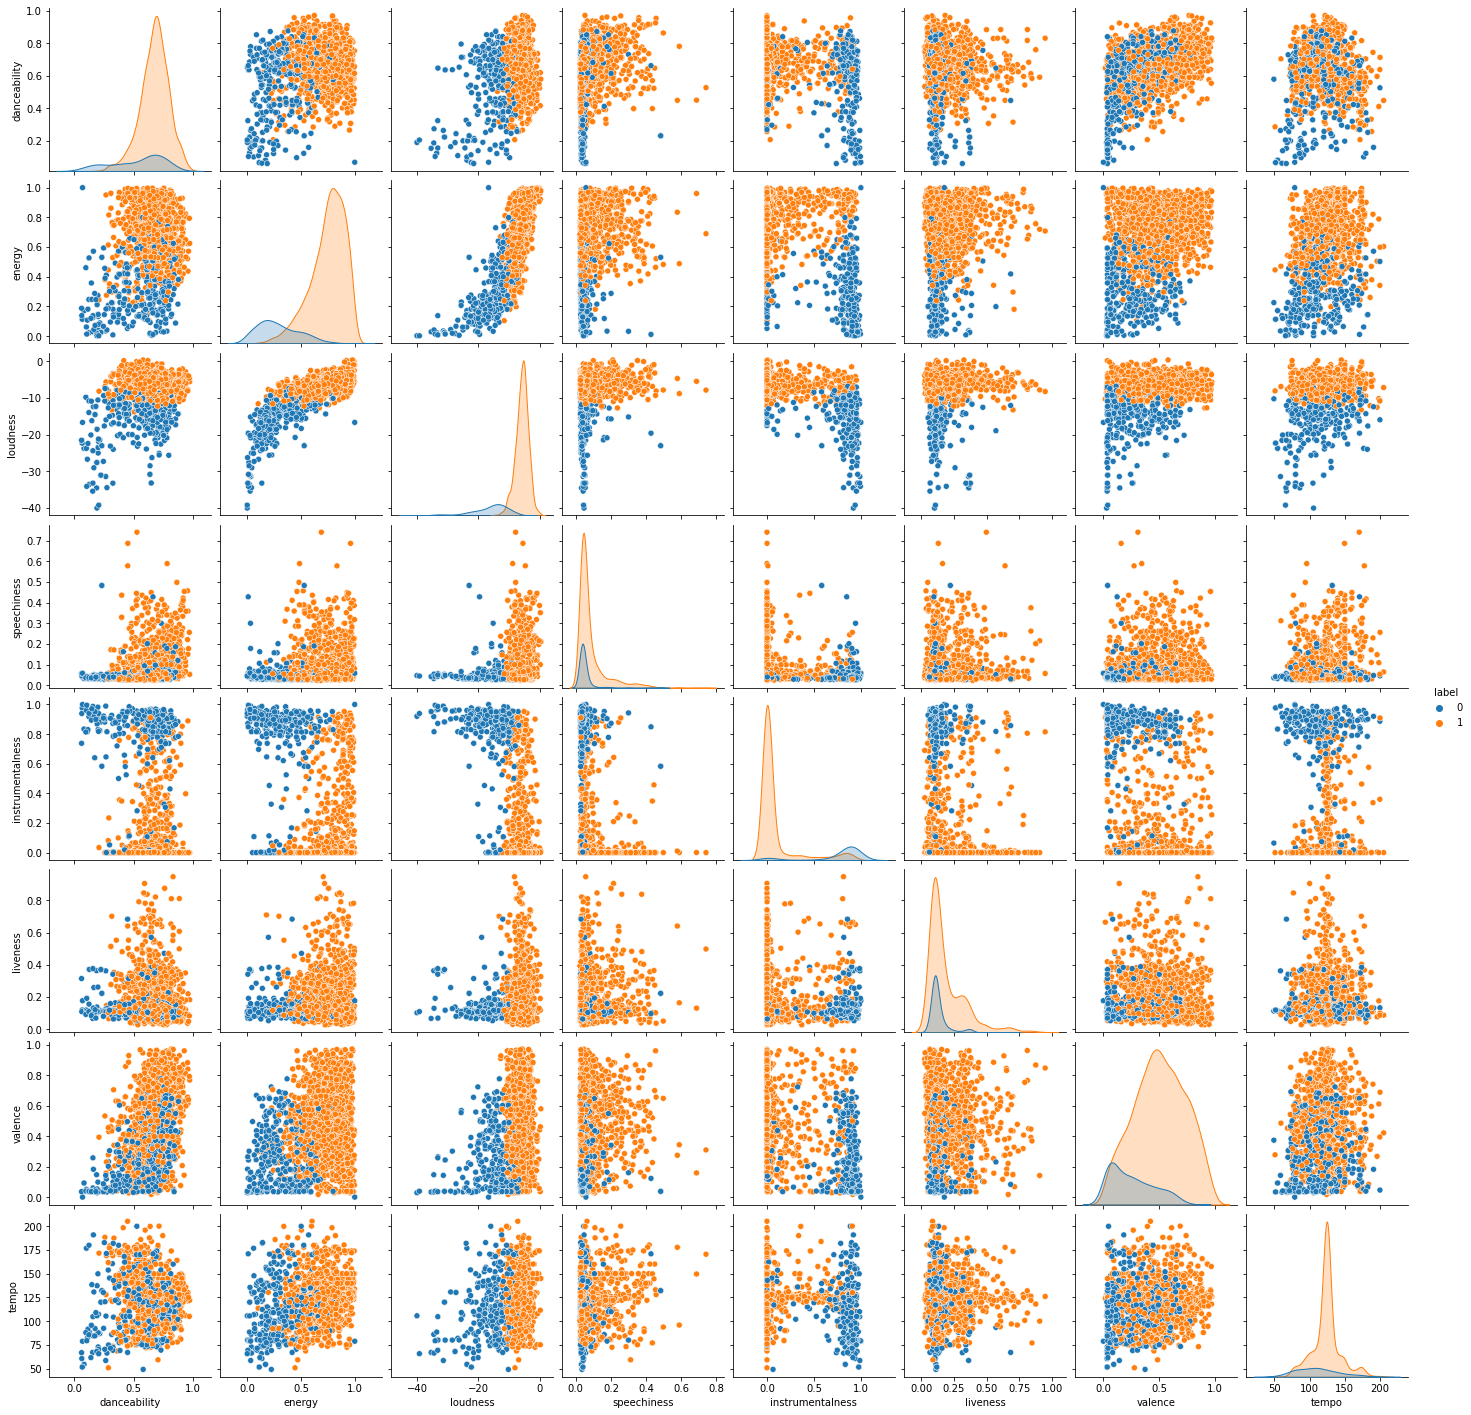

In [90]:
sns.pairplot(new_X, hue = 'label');

In [91]:
kmeans.inertia_

12794.884090449834

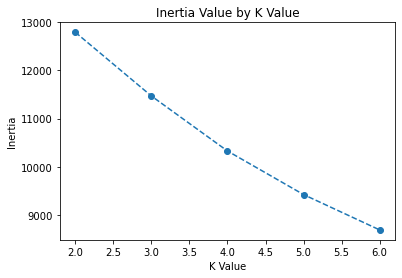

In [92]:
inertias = []
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k).fit(X_scaled)
    inertias.append(kmeans.inertia_)
plt.plot(range(2, 7), inertias, '--o')
plt.xlabel('K Value')
plt.ylabel('Inertia')
plt.title('Inertia Value by K Value');

In [93]:
metrics.silhouette_score(X_scaled, kmeans.labels_)

0.1690632928675223

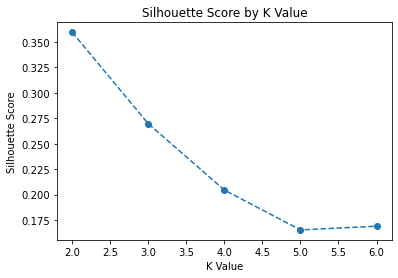

In [94]:
silhouettes = []
for k in range (2, 7):
    kmeans = KMeans(n_clusters=k, random_state = 42).fit(X_scaled)
    silhouettes.append(silhouette_score(X_scaled, kmeans.labels_))
plt.plot(range(2, 7), silhouettes, '--o')
plt.xlabel('K Value')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score by K Value');

In [95]:
new_X.head()

danceability  energy  loudness  speechiness instrumentalness  liveness  \
0         0.750   0.797    -4.826       0.1180                0    0.3920   
1         0.738   0.750    -3.654       0.2190          0.00976    0.1740   
2         0.796   0.798    -6.312       0.0317         0.000042    0.0952   
3         0.736   0.827    -3.902       0.0643          0.00828    0.3510   
4         0.429   0.905    -2.930       0.0512                0    0.0714   

   valence    tempo genre  label  
0    0.523  105.949     0      1  
1    0.342  112.009     0      1  
2    0.942  116.032     0      1  
3    0.814  125.008     0      1  
4    0.659  121.025     0      1

In [96]:
result = pd.concat([df, new_X], axis=1, join="inner")

In [97]:
result.head()

artist                      album                  track_name  \
0           Kygo  Dancing Feet (feat. DNCE)   Dancing Feet (feat. DNCE)   
1     KAYTRANADA                Intimidated  Intimidated (feat. H.E.R.)   
2     Elton John    Cold Heart (PNAU Remix)     Cold Heart - PNAU Remix   
3      BLOND:ISH                       Sete                        Sete   
4  Years & Years               Sweet Talker                Sweet Talker   

   danceability energy loudness  speechiness  instrumentalness  liveness  \
0         0.750  0.797   -4.826       0.1180                 0    0.3920   
1         0.738  0.750   -3.654       0.2190           0.00976    0.1740   
2         0.796  0.798   -6.312       0.0317          0.000042    0.0952   
3         0.736  0.827   -3.902       0.0643           0.00828    0.3510   
4         0.429  0.905   -2.930       0.0512                 0    0.0714   

   valence  ...  danceability energy loudness  speechiness  instrumentalness  \
0    0.523  ...         0.750  0.797   -4.826       0.1180                 0   
1    0.342  ...         0.738  0.750   -3.654       0.2190           0.00976   
2    0.942  ...         0.796  0.798   -6.312       0.0317          0.000042   
3    0.814  ...         0.736  0.827   -3.902       0.0643           0.00828   
4    0.659  ...         0.429  0.905   -2.930       0.0512                 0   

   liveness  valence    tempo  genre  label  
0    0.3920    0.523  105.949      0      1  
1    0.1740    0.342  112.009      0      1  
2    0.0952    0.942  116.032      0      1  
3    0.3510    0.814  125.008      0      1  
4    0.0714    0.659  121.025      0      1  

[5 rows x 23 columns]

In [98]:
result = result.loc[:,~result.columns.duplicated()]

In [99]:
result.head()

artist                      album                  track_name  \
0           Kygo  Dancing Feet (feat. DNCE)   Dancing Feet (feat. DNCE)   
1     KAYTRANADA                Intimidated  Intimidated (feat. H.E.R.)   
2     Elton John    Cold Heart (PNAU Remix)     Cold Heart - PNAU Remix   
3      BLOND:ISH                       Sete                        Sete   
4  Years & Years               Sweet Talker                Sweet Talker   

   danceability  energy  loudness  speechiness instrumentalness  liveness  \
0         0.750   0.797    -4.826       0.1180                0    0.3920   
1         0.738   0.750    -3.654       0.2190          0.00976    0.1740   
2         0.796   0.798    -6.312       0.0317         0.000042    0.0952   
3         0.736   0.827    -3.902       0.0643          0.00828    0.3510   
4         0.429   0.905    -2.930       0.0512                0    0.0714   

   valence    tempo     playlist genre  label  
0    0.523  105.949  dance_party     0      1  
1    0.342  112.009  dance_party     0      1  
2    0.942  116.032  dance_party     0      1  
3    0.814  125.008  dance_party     0      1  
4    0.659  121.025  dance_party     0      1

In [100]:
result.loc[(result['label'] == 0)]

artist                                      album  \
132                 Sia               The Girl You Lost To Cocaine   
141             Orbital                                  Orbital 2   
259              ARTBAT                                  Our Space   
295                Argy                                     Tataki   
590           Echosmith  Tell Her You Love Her (feat. Mat Kearney)   
...                 ...                                        ...   
1865                Uma                                  Astronaut   
1869          Lucy Rose                Question It All / White Car   
1876  Rachel Chinouriri                         Beautiful Disaster   
1886                Uly                                 cold water   
1887          SAM DOTIA                                Uriah's Cry   

                                             track_name  danceability  energy  \
132   The Girl You Lost to Cocaine - Sander van Door...         0.756   0.505   
141                               Halcyon and On and On         0.577   0.729   
259                                    Our Space - Edit         0.701   0.589   
295                                              Tataki         0.826   0.401   
590           Tell Her You Love Her (feat. Mat Kearney)         0.287   0.208   
...                                                 ...           ...     ...   
1865                                          Astronaut         0.423   0.250   
1869                                    Question It All         0.612   0.399   
1876                                 Beautiful Disaster         0.296   0.301   
1886                                         cold water         0.617   0.107   
1887                                        Uriah's Cry         0.329   0.128   

      loudness  speechiness instrumentalness  liveness  valence    tempo  \
132    -12.567       0.0804            0.881    0.4710   0.1030  128.066   
141    -14.376       0.0319            0.928    0.1840   0.1770  126.988   
259    -10.028       0.0666            0.873    0.1010   0.0326  124.011   
295    -11.684       0.1170            0.795    0.0999   0.0561  122.017   
590    -11.300       0.0368                0    0.1190   0.2330   74.889   
...        ...          ...              ...       ...      ...      ...   
1865   -12.878       0.0604           0.0182    0.1510   0.2360  162.231   
1869   -11.904       0.0313            0.107    0.1100   0.1820  141.870   
1876   -15.031       0.0388            0.052    0.1170   0.3050  145.440   
1886   -18.342       0.0685            0.697    0.1030   0.1660  141.970   
1887   -16.762       0.0397          0.00331    0.0622   0.1380  142.960   

                playlist genre  label  
132       dance_classics     0      0  
141       dance_classics     0      0  
259         dance_rising     0      0  
295         dance_rising     0      0  
590          viral_dance     0      0  
...                  ...   ...    ...  
1865  your_office_stereo     2      0  
1869  your_office_stereo     2      0  
1876  your_office_stereo     2      0  
1886  your_office_stereo     2      0  
1887  your_office_stereo     2      0  

[298 rows x 14 columns]

In [101]:
result.loc[(result['label'] == 1)]

artist                      album                  track_name  \
0              Kygo  Dancing Feet (feat. DNCE)   Dancing Feet (feat. DNCE)   
1        KAYTRANADA                Intimidated  Intimidated (feat. H.E.R.)   
2        Elton John    Cold Heart (PNAU Remix)     Cold Heart - PNAU Remix   
3         BLOND:ISH                       Sete                        Sete   
4     Years & Years               Sweet Talker                Sweet Talker   
...             ...                        ...                         ...   
1881   Damon Albarn         Royal Morning Blue   Royal Morning Blue - Edit   
1882  Aby Coulibaly                     Taurus                      Taurus   
1883     Fenne Lily                   Alapathy                    Alapathy   
1884    Biffy Clyro   A Celebration Of Endings                       Space   
1885         Dekker   Tethered, Wrapped Around    Tethered, Wrapped Around   

      danceability  energy  loudness  speechiness instrumentalness  liveness  \
0            0.750   0.797    -4.826       0.1180                0    0.3920   
1            0.738   0.750    -3.654       0.2190          0.00976    0.1740   
2            0.796   0.798    -6.312       0.0317         0.000042    0.0952   
3            0.736   0.827    -3.902       0.0643          0.00828    0.3510   
4            0.429   0.905    -2.930       0.0512                0    0.0714   
...            ...     ...       ...          ...              ...       ...   
1881         0.672   0.816    -7.822       0.0286          0.00301    0.1470   
1882         0.757   0.487    -8.187       0.3890         0.000047    0.1260   
1883         0.554   0.911    -6.282       0.0292            0.542    0.0668   
1884         0.457   0.559    -5.170       0.0270              0.0    0.1930   
1885         0.769   0.238   -11.598       0.0555           0.0461    0.1160   

      valence    tempo            playlist genre  label  
0       0.523  105.949         dance_party     0      1  
1       0.342  112.009         dance_party     0      1  
2       0.942  116.032         dance_party     0      1  
3       0.814  125.008         dance_party     0      1  
4       0.659  121.025         dance_party     0      1  
...       ...      ...                 ...   ...    ...  
1881    0.612  126.064  your_office_stereo     2      1  
1882    0.136   89.002  your_office_stereo     2      1  
1883    0.968  157.621  your_office_stereo     2      1  
1884    0.410  156.907  your_office_stereo     2      1  
1885    0.706   92.093  your_office_stereo     2      1  

[1589 rows x 14 columns]

In [102]:
result['label'].value_counts()

1    1589
0     298
Name: label, dtype: int64

In [103]:
result.shape

(1887, 14)

#### Conclusion
> I decided to give k-means clustering a go for a little practice and to reach some interesting and fun conclusions. It was interesting to play with the kmeans model to see how it would cluster groups of songs together, then rely on some earlier Python skills to concatenate the data back together and see just how a Kygo song could end up in the same cluster as an Elton John song.

### Project Conclusion
> I had a great time applying skills from all parts of the course, from the earliest Python skills all the way through to our last topic on clustering. 
> Song characteristic prediction, as presented in this project, is a difficult prediction problem. All told, the random forest regressor was best at doing it, with about _ accuracy. If I had more time, I would add a few more variables into my multiple regression model on through my neural networks to see if this would affect predictive power for a song's energy level.

### More Information / Stay in Touch
> Feel free to dm me for any information related to this project or to connect and stay in touch!
>> austin.ed.spivey@gmail.com, LinkedIn: austin-spivey